# Couldn't fix issues with matrices dimensions, might be easy, but really I can't find it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD


2024-11-06 15:13:10.035074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 15:13:10.035776: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 15:13:10.040242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 15:13:10.051786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 15:13:10.073569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# Last working DFA model

In [3]:

# Define the model
class DFAModel(tf.keras.Model):
    def __init__(self, output_size):
        super(DFAModel, self).__init__()
        self.dense1 = layers.Dense(50, activation='tanh')
        self.dense2 = layers.Dense(50, activation='tanh')
        self.dense3 = layers.Dense(50, activation='tanh')
        self.output_layer = layers.Dense(output_size)
        
        # Random feedback weights for DFA
        # self.feedback1 = tf.random.normal((50, 2), dtype=tf.float32)  
        # self.feedback2 = tf.random.normal((50, 2), dtype=tf.float32)  
        # self.feedback3 = tf.random.normal((50, 2), dtype=tf.float32)  

        self.feedback_mat = [
             tf.random.normal((output_size,50), dtype=tf.float32) for _ in range(3) # (2,50) for dimension matching
        ]


    def call(self, inputs, no_feedback):
        # Forward pass
        a1 = self.dense1(inputs)  # Pre-activation output of layer 1
        h1 = tf.nn.tanh(a1)  # Activation output of layer 1
        
        a2 = self.dense2(h1)  # Pre-activation output of layer 2
        h2 = tf.nn.tanh(a2)  # Activation output of layer 2
        
        a3 = self.dense3(h2)  # Pre-activation output of layer 3
        h3 = tf.nn.tanh(a3)  # Activation output of layer 3
        
        ANN_output = self.output_layer(h3)  # Final output



        if no_feedback:return ANN_output # Use this when dealing with backprop
        else:return ANN_output, a1, a2, a3, h1, h2, h3  # Return output and pre-activations



# Anas like model

In [4]:

# Define the model
class DFAModel_anas(tf.keras.Model):
    def __init__(self, output_size):
        super(DFAModel_anas, self).__init__()
        self.dense1 = layers.Dense(2, activation='tanh')
        self.dense2 = layers.Dense(40, activation='tanh')
        self.output_layer = layers.Dense(output_size)
        
        # Random feedback weights for DFA
        # self.feedback1 = tf.random.normal((50, 2), dtype=tf.float32)  
        # self.feedback2 = tf.random.normal((50, 2), dtype=tf.float32)  
        # self.feedback3 = tf.random.normal((50, 2), dtype=tf.float32)  

        self.feedback_mat = [
             tf.random.normal((output_size, 2), dtype=tf.float32),
             tf.random.normal((output_size,40), dtype=tf.float32)
        ]


    def call(self, inputs, no_feedback):
        # Forward pass
        a1 = self.dense1(inputs)  # Pre-activation output of layer 1
        h1 = tf.nn.tanh(a1)  # Activation output of layer 1
        
        a2 = self.dense2(h1)  # Pre-activation output of layer 2
        h2 = tf.nn.tanh(a2)  # Activation output of layer 2
        
        ANN_output = self.output_layer(h2)  # Final output



        if no_feedback:return ANN_output # Use this when dealing with backprop
        else:return ANN_output, a1, a2,  h1, h2 # Return output and pre-activations



# DFA model support for different input, hidden and output layer sizes

In [5]:
class DFAModel_dynamic(tf.keras.Model):
    def __init__(self, input_size, hidden_number, hidden_sizes, output_size, act_fn='tanh'):
        super(DFAModel_dynamic, self).__init__()
        
        # Input layer
        self.input_layer = layers.Dense(input_size, activation=act_fn)

        # Hidden layers
        self.hidden_layers = []
        for _ in range(hidden_number):
            self.hidden_layers.append(layers.Dense(hidden_sizes, activation=act_fn))

        # Output layer
        self.output_layer = layers.Dense(output_size)

        # Feedback matrices for DFA
        self.feedback_mat = [
            tf.random.normal((output_size, input_size), dtype=tf.float32)
        ] + [
            tf.random.normal((output_size, hidden_sizes), dtype=tf.float32) for _ in range( hidden_number)
        ]


        # print(self.feedback_mat)

    def call(self, inputs, no_feedback):
        # Forward pass through input layer
        x = self.input_layer(inputs)
        
        # Forward pass through hidden layers
        hidden_activations = []
        for layer in self.hidden_layers:
            x = tf.nn.tanh(layer(x))  # Activation output of hidden layer
            hidden_activations.append(x)
        
        # Final output layer
        ANN_output = self.output_layer(x)

        if no_feedback:
            return ANN_output  # Use this when dealing with backprop
        else:
            return ANN_output, hidden_activations  # Return output and activations for DFA


# Custom backpropagation

In [6]:
# Custom DFA weight update function
def custom_backprop(model, inputs, targets, learning_rate=0.01):

    # CURRENTLY NOT DFA BUT BACKPROP FOR TESTING PURPOSES


    # Define the loss function
    loss_fn = tf.keras.losses.MeanSquaredError()

    with tf.GradientTape() as tape:
        # Forward pass through the model
        outputs = model(inputs, no_feedback=True)  # Forward pass through the entire model
        loss = loss_fn(targets, outputs)  # Compute the loss

    # Compute gradients for all trainable variables in the model
    gradients = tape.gradient(loss, model.trainable_variables)

    # Update weights for all layers using backpropagation
    for var, grad in zip(model.trainable_variables, gradients):
        var.assign_sub(learning_rate * grad)


# working Custom DFA for 3 layers

In [7]:

# Custom DFA weight update function
def custom_dfa_training_step(model, inputs, targets, learning_rate=0.01):
    
    # Get batch size
    batch_size = inputs.shape[0]
    
    # 1. Forward pass to get the output from the model
    ANN_output, a1, a2, a3, h1, h2, h3 = model(inputs, no_feedback=False)
    
    # 2. Define the error
    error = ANN_output - targets  # Error as defined: ANN_output - targets


    # 3. Define random matrices for weight updates (feedback)
    # They are initialized in the model

    # 4. Update weights for each layer

    def ComputeLayerDeltaW(i_layer, a, error, h):
        B = model.feedback_mat[i_layer] # Random B matrix
        d_activation = tanh_derivative(a)  # F' 
        delta_a = np.dot(error, B) * d_activation  # delta_a = (B.e)xF'(a)
        # Convert delta_a1 to float32 if necessary
        delta_a = tf.convert_to_tensor(delta_a, dtype=tf.float32)

        # Normalize by batch size
        delta_a /= batch_size  # Avoid exponential growth

        delta_a_transpose = tf.transpose(delta_a)
        delta_W = -tf.matmul(delta_a_transpose, h) # delta_w = -delta_a.h

        return delta_W 

    # 4.2
    delta_W1 = ComputeLayerDeltaW(0, a1, error, inputs)
    delta_W2 = ComputeLayerDeltaW(1, a2, error, h1)
    delta_W3 = ComputeLayerDeltaW(2, a3, error, h2)

    # 4.3 assigning weights
    weights1 = model.dense1.kernel 
    delta_W1 = learning_rate * delta_W1  # Clip the gradient updates
    weights1.assign(weights1 + tf.transpose(delta_W1))

    weights2 = model.dense2.kernel  
    delta_W2 = learning_rate * delta_W2  # Clip the gradient updates
    weights2.assign(weights2 + tf.transpose(delta_W2))

    weights3 = model.dense3.kernel  
    delta_W3 = learning_rate * delta_W3  # Clip the gradient updates
    weights3.assign(weights3 + tf.transpose(delta_W3))

    # Update for the output layer
    output_weights = model.output_layer.kernel  # Get the weights of the output layer
    delta_output_weights = -tf.matmul(tf.transpose(error), h3)   # Compute the update for output layer
    output_weights.assign(output_weights + tf.transpose(delta_output_weights))  # Update the output layer weights


# Anas like DFA for 2 layers

In [8]:

# Custom DFA weight update function
def anas_dfa_training_step(model, inputs, targets, learning_rate=0.01):
    
    # Get batch size
    batch_size = inputs.shape[0]
    
    # 1. Forward pass to get the output from the model
    ANN_output, a1, a2, h1, h2 = model(inputs, no_feedback=False)
    
    # 2. Define the error
    error = ANN_output - targets  # Error as defined: ANN_output - targets


    # 3. Define random matrices for weight updates (feedback)
    # They are initialized in the model

    # 4. Update weights for each layer

    def ComputeLayerDeltaW(i_layer, a, error, h):
        B = model.feedback_mat[i_layer] # Random B matrix
        d_activation = tanh_derivative(a)  # F' 
        delta_a = np.dot(error, B) * d_activation  # delta_a = (B.e)xF'(a)
        # Convert delta_a1 to float32 if necessary
        delta_a = tf.convert_to_tensor(delta_a, dtype=tf.float32)

        # Normalize by batch size
        delta_a /= batch_size  # Avoid exponential growth

        delta_a_transpose = tf.transpose(delta_a)
        delta_W = -tf.matmul(delta_a_transpose, h) # delta_w = -delta_a.h

        return delta_W 

    # 4.2
    delta_W1 = ComputeLayerDeltaW(0, a1, error, inputs)
    delta_W2 = ComputeLayerDeltaW(1, a2, error, h1)

    # 4.3 assigning weights
    weights1 = model.dense1.kernel 
    delta_W1 = learning_rate * delta_W1  # Clip the gradient updates
    weights1.assign(weights1 + tf.transpose(delta_W1))

    weights2 = model.dense2.kernel  
    delta_W2 = learning_rate * delta_W2  # Clip the gradient updates
    weights2.assign(weights2 + tf.transpose(delta_W2))


    # Update for the output layer
    output_weights = model.output_layer.kernel  # Get the weights of the output layer
    delta_output_weights = -tf.matmul(tf.transpose(error), h2)   # Compute the update for output layer
    output_weights.assign(output_weights + tf.transpose(delta_output_weights))  # Update the output layer weights


# Custom DFA working with dynamic model

In [9]:
def dfa_dynamic(model, inputs, targets, learning_rate=0.01):
    # Get batch size
    batch_size = inputs.shape[0]
    
    # 1. Forward pass to get the output and hidden activations from the model
    ANN_output, hidden_activations = model(inputs, no_feedback=False)
    
    # 2. Define the error
    error = ANN_output - targets  # Error as defined: ANN_output - targets
    
    # 3. Update weights for each hidden layer
    def ComputeLayerDeltaW(i_layer, activation, error, inputs_or_hidden):
        B = model.feedback_mat[i_layer]  # Random B matrix for the layer
        d_activation = tanh_derivative(activation)  # Derivative of the activation function
        delta_a = tf.matmul(error, B) * d_activation  # delta_a = (B.e) * F'(activation)
        
        # Normalize by batch size
        delta_a /= batch_size

        # Compute weight update
        delta_W = -tf.matmul(tf.transpose(delta_a), inputs_or_hidden)  # delta_W = -delta_a * inputs_or_hidden
        return delta_W

    # 4. Loop through each hidden layer and update weights
    # The first layer takes the inputs directly
    delta_W1 = ComputeLayerDeltaW(0, hidden_activations[0], error, inputs)
    
    # Assign weights for the first layer
    weights1 = model.input_layer.kernel
    delta_W1 = learning_rate * delta_W1
    weights1.assign(tf.transpose(delta_W1))

    # Handle all hidden layers
    for i in range(1, len(hidden_activations)):
        print(i)
        delta_W_hidden = ComputeLayerDeltaW(i, hidden_activations[i], error, hidden_activations[i-1])
        
        # Assign weights for the hidden layer
        weights_hidden = model.hidden_layers[i-1].kernel
        delta_W_hidden = learning_rate * delta_W_hidden
        weights_hidden.assign(tf.transpose(delta_W_hidden))
    
    # 5. Update the output layer
    output_weights = model.output_layer.kernel  # Get the weights of the output layer
    delta_output_weights = -tf.matmul(tf.transpose(error), hidden_activations[-1])  # delta_output_weights = -error * last hidden activation
    delta_output_weights /= batch_size  # Normalize by batch size
    output_weights.assign(tf.transpose(delta_output_weights))  # Update the output layer weights


# Test with XOR

Model: "dfa_model_anas"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 2)                 │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 40)                │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 1)                 │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

epcoh: 0
epcoh: 1
epcoh: 2
epcoh: 3
epcoh: 4
epcoh: 5
epcoh: 6
epcoh: 7
epcoh: 8
epcoh: 9
epcoh: 10
epcoh: 11
epcoh: 12
epcoh: 13
epcoh: 14
epcoh: 15
epcoh: 16
epcoh: 17
epcoh: 18
epcoh: 19
epcoh: 20
epcoh: 21
epcoh: 22
epcoh: 23
epcoh: 24
epcoh: 25
epcoh: 26
epcoh: 27
epcoh: 28
epcoh: 29
epcoh: 30
epcoh: 31
epcoh: 32
epcoh: 33
epcoh: 34
epcoh: 35
epcoh: 36
epcoh: 37
epcoh: 38
epcoh: 39
epcoh: 40
epcoh: 41
epcoh: 42
epcoh: 43
epcoh: 44
epcoh: 45
epcoh: 46
epcoh: 47
epcoh: 48
epcoh: 49
epcoh: 50
epcoh: 51
epcoh: 52
epcoh: 53
epcoh: 54
epcoh: 55
epcoh: 56
epcoh: 57
epcoh: 58
epcoh: 59
epcoh: 60
epcoh: 61
epcoh: 62
epcoh: 63
epcoh: 64
epcoh: 65
epcoh: 66
epcoh: 67
epcoh: 68
epcoh: 69
epcoh: 70
epcoh: 71
epcoh: 72
epcoh: 73
epcoh: 74
epcoh: 75
epcoh: 76
epcoh: 77
epcoh: 78
epcoh: 79
epcoh: 80
epcoh: 81
epcoh: 82
epcoh: 83
epcoh: 84
epcoh: 85
epcoh: 86
epcoh: 87
epcoh: 88
epcoh: 89
epcoh: 90
epcoh: 91
epcoh: 92
epcoh: 93
epcoh: 94
epcoh: 95
epcoh: 96
epcoh: 97
epcoh: 98
epcoh: 99
epcoh: 100

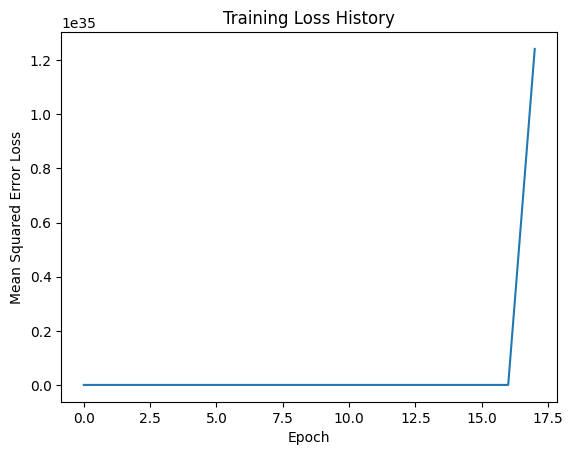

In [10]:
# dfa_step = custom_dfa_training_step
# dfa_model = DFAModel(1)

dfa_step = anas_dfa_training_step
dfa_model = DFAModel_anas(1)

# dfa_step = dfa_dynamic
# dfa_model = DFAModel_dynamic(2, 1, 40, 1, 'tanh')


# Data
data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # XOR inputs
targets = np.array([[0], [1], [1], [0]])  # XOR targets


# Forward pass with dummy data to build the model
dummy_input = tf.random.normal((1, data.shape[1]))  # Match the shape of your input data
_ = dfa_model(dummy_input, no_feedback=True)  # Perform a forward pass to build the model
dfa_model.summary()

# losses function and list
loss_fn = tf.keras.losses.MeanSquaredError()
loss_history = []

# Training loop
epochs = 1000
batch_size = 3
learning_rate = 0.01

dataset = tf.convert_to_tensor(data, dtype=tf.float32)
expected_results = tf.convert_to_tensor(targets, dtype=tf.float32)

for epoch in range(epochs):
    print(f'epcoh: {epoch}')
    for i in range(0, len(dataset), batch_size):
        x_batch = dataset[i:i + batch_size]
        y_batch = expected_results[i:i + batch_size]
        dfa_step(dfa_model, x_batch, y_batch, learning_rate)
        # custom_backprop(dfa_model, x_batch, y_batch, learning_rate) # <= This works well

    pred = dfa_model(x_batch, no_feedback=True)
    batch_loss = loss_fn(y_batch, pred)
    loss_history.append(batch_loss)

pred = dfa_model(data, no_feedback=True)

for i in range(len(pred)):
    print(data[i], pred[i])



plt.plot(loss_history)
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.show()

In [11]:
print(dfa_model.feedback_mat)

# Assuming dfa_model has been instantiated and feedback_mat exists
feedback_matrices = dfa_model.feedback_mat

# Create a table header
print(f"{'Matrix':<10} {'Frobenius Norm':<20} {'Rank':<10} {'Condition Number':<20} {'Min Value':<15} {'Max Value':<15} {'Average':<15} {'Sum':<15}")

# Compute and print characteristics for each matrix
for idx, mat in enumerate(feedback_matrices):
    mat_np = mat.numpy()  # Convert to NumPy array if necessary
    
    # Frobenius Norm
    frob_norm = np.linalg.norm(mat_np, 'fro')
    
    # Rank
    rank = np.linalg.matrix_rank(mat_np)
    
    # Condition Number (use np.linalg.cond for non-square matrices)
    try:
        cond_num = np.linalg.cond(mat_np)
    except np.linalg.LinAlgError:
        cond_num = np.inf  # If the condition number cannot be computed, set to infinity
    
    # Min and Max Values
    min_val = np.min(mat_np)
    max_val = np.max(mat_np)
    
    # Average and Sum of all elements
    avg_val = np.mean(mat_np)
    total_sum = np.sum(mat_np)
    
    # Print the results
    print(f"{idx:<10} {frob_norm:<20.6f} {rank:<10} {cond_num:<20.6f} {min_val:<15.6f} {max_val:<15.6f} {avg_val:<15.6f} {total_sum:<15.6f}")




[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.035509 , -1.0815377]], dtype=float32)>, <tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[ 0.4436265 ,  0.40576193,  1.6600581 , -1.455826  ,  1.3965882 ,
        -0.0462802 , -0.69298774,  0.8014882 ,  0.27867788,  1.2127836 ,
        -2.0153408 , -0.40689582,  0.04296972, -1.3317323 ,  1.4408419 ,
         1.1257383 ,  0.16937268, -0.28693125,  0.12454437,  0.09126619,
        -1.8368932 ,  0.2274011 ,  0.8482541 , -0.32945195, -2.290909  ,
        -0.74049294, -1.6215048 , -0.06114914, -0.3074192 ,  0.70855474,
        -0.04650941, -0.86513263, -0.71069723, -1.202043  ,  1.8484871 ,
        -1.6053052 , -0.5683419 ,  0.5598701 ,  1.1364251 , -1.051593  ]],
      dtype=float32)>]
Matrix     Frobenius Norm       Rank       Condition Number     Min Value       Max Value       Average         Sum            
0          1.497332             1          1.000000             -1.081538       1.035509        -0.023014       -0.